
<div class="alert alert-success alertsuccess" style="margin-top: 20px">
[Tip]: To execute the Python code in the code cell below, click on the cell to select it and press <kbd>Shift</kbd> + <kbd>Enter</kbd>.
</div>


# Exercise 1: Nearest Neighbor Classifier for Handwritten Digit Recognition 

## Due Date: Thursday, 16.11.23, 11 am, via Moodle

In this notebook we will build a classifier that takes an image of a handwritten digit and outputs a label $y \in \{0-9\}$. We will look at a particularly simple strategy for this problem, known as the **nearest neighbor classifier**.

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`
* `joblib`
* `ipywidgets`

**The notebook contains 10 tasks for you to solve.**

*The MNIST dataset*
1. Task: Compute the number of images per class of MNIST

*Implement the Nearest Neighbor Classifier in Python*

2. Task: Implement the Euclidean distance ($L_2$-distance)
3. Task: Implement 1-Nearest-Neighbor
4. Task: Implement 1-nearest-neighbor classification

*Error Analysis*

5. Task: Error Analysis
6. Task: Report the test error
7. Task: Report the train error
8. Task: Explain the train error 

*Using Scikit-Learn and Hyperparameter Optimization*

9. Task: Optimize hyper-parameter $k$ using cross-validation
10. Task: Optimize hyper-parameters $k$ and $p$ using grid-search

**Solving a task gives one point. You must obtain 50% of the points over all exercises to pass.**

## Submission 

Hand in this assignment via Moodle.

### We will first check if the required packages are installed

In [102]:
# uncomment the below lines, if needed
import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install ipywidgets
# !{sys.executable} -m pip install joblib

In [103]:
import sklearn
print(sklearn.__version__)

import ipywidgets as widgets
print(widgets.__version__)

import joblib
print(joblib.__version__)

1.2.1
7.6.5
1.1.1


If this gives an error, we might have to install the missing package first. See above.


## The MNIST dataset
We have seen `MNIST`  in the lecture. It is a classic dataset used in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 samples and the test set contains 10,000 samples. 

In this notebook we will be working with a subset of this data: a training set of **7,500** samples and a test set of **1,000** samples.

In [104]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from numpy.testing import assert_almost_equal

import time
import requests
import io

def load_remote(URL):
    response = requests.get(URL)
    response.raise_for_status()
    return np.load(io.BytesIO(response.content))

def load_data(local):
    ## Load the training and testing set 
    # use these, if you want to work locally
    if local:
        train_data = np.load('MNIST/train_data.npy')
        train_labels = np.load('MNIST/train_labels.npy')
        test_data = np.load('MNIST/test_data.npy')
        test_labels = np.load('MNIST/test_labels.npy')

    ## Load the training and testing set from remote 
    ## Usefull for JupyterHub or Colab-Development
    if not local:
        test_data = load_remote("https://box.hu-berlin.de/f/8db2251a109a4037af20/?dl=1")
        train_data = load_remote("https://box.hu-berlin.de/f/2d95919ae6784be1b905/?dl=1")
        train_labels = load_remote("https://box.hu-berlin.de/f/4124ffe96274489793ca/?dl=1")
        test_labels = load_remote("https://box.hu-berlin.de/f/f1b7154075d8480aaa8d/?dl=1")
        
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = load_data(False)

In [105]:
## Print out the dimensions
print(f"Training dataset dimensions:\t {train_data.shape}")
print(f"Number of training labels:\t {train_labels.shape[0]}")
print(f"Testing dataset dimensions:\t {test_data.shape}")
print(f"Number of testing labels:\t {test_labels.shape[0]}")

Training dataset dimensions:	 (7500, 784)
Number of training labels:	 7500
Testing dataset dimensions:	 (1000, 784)
Number of testing labels:	 1000


### Task 1: Compute the number of images per class of MNIST

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Your first task is to return a dictionary that counts the number of images for each class. E.g. {0: 750, 1: 750, 2: 750, 3: ...}

Implement the following method

```python
def imagesPerClass(x):

```

that returns a **dictionary** of counts.

</div>

*Hint: Useful utility methods are ```np.unique() from numpy ``` or ```Counter() from collections```.*

In [106]:
def imagesPerClass(labels):
    # YOUR CODE HERE
    dic = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    for label in labels:
        dic[label] = dic[label] + 1
    return dic

In [107]:
img_per_class = imagesPerClass(train_labels)

print ("Images per Class:")
print (img_per_class)

## Check that your method returns a dictionary
assert type(img_per_class) == dict

## Check that your dictionary has 10 entries
assert len(img_per_class) == 10


Images per Class:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}


## Visualizing the data
Each digit is stored as 784-dimensional vector. To visualize a digit, we first reshape it to a 28x28 image.

In [108]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray_r)
    plt.show()

## Define a function that takes an index into a particular 
## data set ("train" or "test") and displays that image.
def vis_image(index, dataset, labels):
    show_digit(dataset[index])
    print("Label " + str(labels[index]))

## View the first data point in the training set
@interact
def vis_image_train(index=(0,len(train_data)-1,1)):
    vis_image(index, train_data, train_labels)

## Now view the first data point in the test set
@interact
def vis_image_test(index=(0,len(test_data)-1,1)):
    vis_image(index, test_data, test_labels)
    


interactive(children=(IntSlider(value=3749, description='index', max=7499), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=499, description='index', max=999), Output()), _dom_classes=('widget-int…

## Squared Euclidean distance  ($L_2$-distance)

To compute nearest neighbors in our data set, we need to first be able to compute distances between samples. 

A common distance function is the **Euclidean distance**: for two input vectors $x, y \in \mathbb{R}^n$, their Euclidean distance is defined as 

$$dist(x,y)=\|x - y\|_2 = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$$

For performance reasons, we omit the square root, and simply the compute **squared Euclidean distance**:

$${dist}^2(x,y)=\|x - y\|_2^2 = \sum_{i=1}^n (x_i - y_i)^2$$

**Note:** For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^n$, we have 
$$\|x - y\|_2 \leq \|x - z\|_2 \text{ if and only if } \|x - y\|_2^2 \leq \|x - z\|_2^2$$

### Task 2: Implement the Euclidean distance ($L_2$-distance)

We need to be able to compute the **squared** Euclidean distance. 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Implement the following function

```python
def squared_dist(x, y):

```

to compute the Euclidean distance between two input vectors x and y.
</div>

In [109]:
## Takes a vector x and a vector y and returns the squared euclidean distance
def squared_dist(x, y):
    # YOUR CODE HERE
    return np.sum((x - y)**2)

Run the following tests to check if your implementation is correct

In [110]:
train_data.shape

(7500, 784)

In [111]:
## Compute distance between a seven and a one in our training set.
print('Squared distance: {:.3f} should be approx. 5816001'.format(squared_dist(train_data[15],train_data[3])))
assert abs(squared_dist(train_data[15],train_data[3]) - 5816001) < 1

# ## Compute distance between a seven and a two in our training set.
print('Squared distance: {:.3f} should be approx. 6440239'.format(squared_dist(train_data[15],train_data[5])))
assert abs(squared_dist(train_data[15],train_data[5]) - 6440239)  < 1

# ## Compute distance between two seven's in our training set.
print('Squared distance: {:.3f} should be approx. 6039965'.format(squared_dist(train_data[15],train_data[29])))
assert abs(squared_dist(train_data[15],train_data[29]) - 6039965) < 1


Squared distance: 5816001.000 should be approx. 5816001
Squared distance: 6440239.000 should be approx. 6440239
Squared distance: 6039965.000 should be approx. 6039965


### Task 3: Implement the 1-Nearest-Neighbor

Now that we have a distance function defined, we can turn to the **1-nearest-neighbor**. 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
First implement the method 

```python
def find_NN(x, train)
```

It should iterate through all samples in **train** and return the **index** of the vector with the smallest Euclidean distance.
</div>

*Hint: A useful utility method is ```np.argmin ``` which returns the index of the minimum in a list of floats.*

In [112]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x, train):
    # YOUR CODE HERE
    min_distance = float('inf')
    nearest_neighbor_idx = None
    
    for i, sample in enumerate(train):
        distance = squared_dist(x, sample)
        if distance < min_distance:
            min_distance = distance
            nearest_neighbor_idx = i
    
    return nearest_neighbor_idx

Run the following tests to check if your implementation is correct

In [113]:
for i in np.arange(10):
    nn = find_NN(train_data[i], train_data)
    print('Found NN: {:d} should be {:d}'.format(nn, i), ("ok" if nn == i else "fail"))
    assert nn == i 


Found NN: 0 should be 0 ok
Found NN: 1 should be 1 ok
Found NN: 2 should be 2 ok
Found NN: 3 should be 3 ok
Found NN: 4 should be 4 ok
Found NN: 5 should be 5 ok
Found NN: 6 should be 6 ok
Found NN: 7 should be 7 ok
Found NN: 8 should be 8 ok
Found NN: 9 should be 9 ok


### Task 4: Implement the 1-Nearest-Neighbor Classification

Now that we have a distance function and the 1-nearest-neighbor defined, we can turn both into a **1-nearest-neighbor classification**. 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Implement the
```python
def NN_classifier(x, train, labels)
```
method. It takes a vector x and returns the class label of its nearest neighbor in train

</div>

*Hint: Use (one or both) of ```find_NN``` and ```squared_dist``` implemented before.*

In [114]:
## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x, train, labels):
    # YOUR CODE HERE
    return labels[find_NN(x, train)]

Run the following tests to check if your implementation is correct

In [115]:
for i in np.arange(10):
    nn = NN_classifier(train_data[i], train_data, train_labels)
    print('Found Class {:d} should be {:d}'.format(nn, train_labels[i]), ("ok" if nn == train_labels[i] else "fail"))
    assert NN_classifier(train_data[i], train_data, train_labels) == train_labels[i]


Found Class 9 should be 9 ok
Found Class 2 should be 2 ok
Found Class 8 should be 8 ok
Found Class 3 should be 3 ok
Found Class 7 should be 7 ok
Found Class 1 should be 1 ok
Found Class 6 should be 6 ok
Found Class 7 should be 7 ok
Found Class 9 should be 9 ok
Found Class 2 should be 2 ok


## Qualitative Error Analysis

To spot problems in the implementation or the model training, it is always useful to look at some concrete mistakes your classifier does

### Let's first plot some successes

NN classification: 0 on test image 0
The test image:


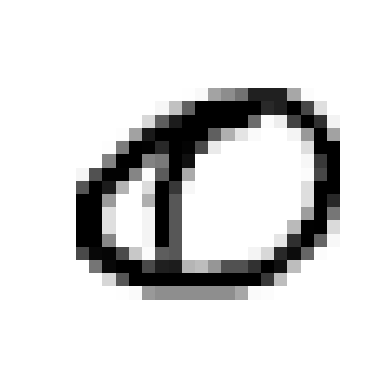

Label 0
Corresponding nearest neighbor:


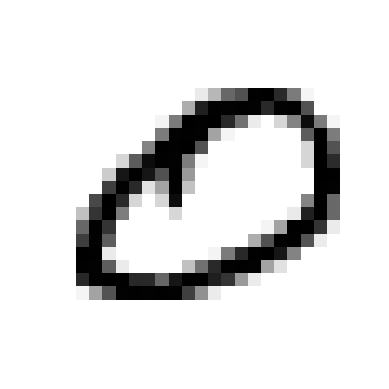

Label 0


In [116]:
for i in np.arange(40):
    nnClass = NN_classifier(test_data[i], train_data, train_labels)
    if (nnClass == test_labels[i]):
        ## A success case:
        print(f"NN classification: {nnClass} on test image {i}")
        print("The test image:")
        vis_image(i, test_data, test_labels)

        print("Corresponding nearest neighbor:")
        vis_image(find_NN(test_data[i], train_data), train_data, train_labels)

        break

### We will now plot some failures

NN classification: 2 on test image 39
The test image:


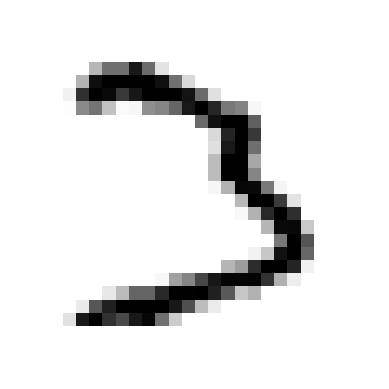

Label 3
Corresponding nearest neighbor:


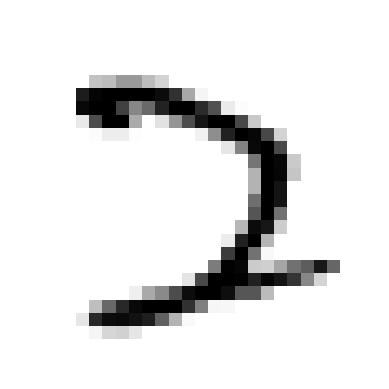

Label 2


In [117]:
for i in range(40) :
    nnClass = NN_classifier(test_data[i], train_data, train_labels)
    if (nnClass != test_labels[i]):
        ## A success case:
        print(f"NN classification: {nnClass} on test image {i}")
        print("The test image:")
        vis_image(i, test_data, test_labels)

        print("Corresponding nearest neighbor:")
        vis_image(find_NN(test_data[i], train_data), train_data, train_labels)

        break

### Task 5: Error Analysis
The above two examples show a success on **image 0** and a failure on **image 4** of the NN classifier.

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Now try the **test image with index 100**.
* What is the index of its nearest neighbor in the training set?
* What label is predicted? Is it the correct label?
    
</div>

NN classification: 4 on test image 100
The test image:


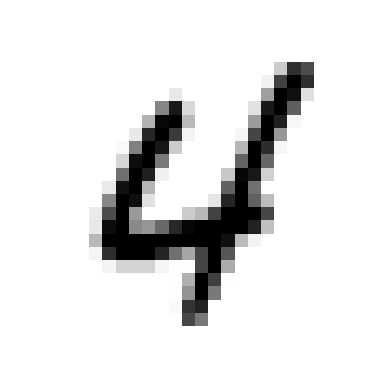

Label 4
Corresponding nearest neighbor:


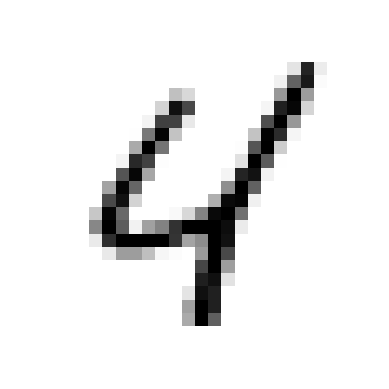

Label 4
index of nearest neighbor: 4711


In [118]:
# Write some code as needed
# And do not forget to write down the answer in the following box
i = 100
nnClass = NN_classifier(test_data[i], train_data, train_labels)
print(f"NN classification: {nnClass} on test image {i}")
print("The test image:")
vis_image(i, test_data, test_labels)
print("Corresponding nearest neighbor:")
vis_image(find_NN(test_data[i], train_data), train_data, train_labels)
print("index of nearest neighbor: " + str(find_NN(test_data[i], train_data)))

The index of the nearest neighbor is 4711.
The predicted label is 4. The correct label is also 4.

## Optional: Processing the full test set

Now let's apply our nearest neighbor classifier to the full data set. 

<div class="alert alert-block alert-danger" style="margin-top: 20px">
Note that to classify each of the $1000$ test point, our code takes a full pass over each of the $7500$ training samples. Thus we should not expect testing to be very fast.     
</div>

**The following code takes up to 17 seconds on an Apple M1 and 142 seconds on Google Colab.**

In [119]:
## Predict on each test data point (and time it!)
def runFullTest():
    from joblib import Parallel, delayed

    t_before = time.time()
    test_predictions = Parallel(n_jobs=-1)(
        delayed(NN_classifier)(test_data[i], train_data, train_labels) for i in range(len(test_labels)))
    t_after = time.time()

    ## Compute the error
    err_positions = np.not_equal(test_predictions, test_labels)
    error = float(np.sum(err_positions))/len(test_labels)

    print('Error of nearest neighbor classifier: {:.1f}%'.format(error*100))
    print("Classification time (seconds): ", t_after - t_before)
   
runFullTest()

Error of nearest neighbor classifier: 4.6%
Classification time (seconds):  22.966156244277954


## Scikit-Learn: k-Nearest-Neighbor Classifier

We will now turn to `scikit-learn`, which provides an efficient implementation of the k-Nearest-Neighbor classifier: [Module k-Nearest Neighbor Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier). 

We will first intialize a 3-Nearest-Neighbor classifier.

In [120]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

All supervised estimators in `scikit-learn` implement a `fit(X, y)` method to fit the model:

In [121]:
knn.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=3)

The `predict(X)` method, given unlabeled observations `X`, returns the predicted labels `y`.

In [122]:
predictions = knn.predict(test_data)

Finally, the `score(X, y)` method computes the mean `accuracy` on the given test data `X` and labels `y`.

In [123]:
score = knn.score(test_data, test_labels)
print('Test accuracy: {:.1f}%'.format(score*100))

Test accuracy: 94.8%


### Task 6: Test Error

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Complete the following method 

```python
def testError(knn, X_test, y_test):
```

to return the 3-NN error on the test data using the trained model `knn`, and test dataset `X_test` with test labels `y_test`.

</div>

In [124]:
def testError(knn, X_test, y_test):
    # YOUR CODE HERE
    predicted_labels = knn.predict(X_test)
    error = 1 - knn.score(X_test, y_test)
    return error

Run the following tests to check if your implementation is correct

In [125]:
print('Test error: {:.1f}%'.format(
    testError(knn, test_data, test_labels)*100))
assert_almost_equal(
    testError(knn, test_data, test_labels), 0.052, decimal=3)

Test error: 5.2%


### Task 7: Report the train error on MNIST

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Complete the following method

```python
def trainError(knn, X_train, y_train):
```

to return the 3-NN error on the train data using the trained model `knn`, and train dataset `X_train` with train labels `y_train`.

</div>

In [126]:
def trainError(knn, X_train, y_train):
    # YOUR CODE HERE
    predicted_labels = knn.predict(X_train)
    error = 1 - knn.score(X_train, y_train)
    return error

Run the following tests to check if your implementation is correct

In [127]:
print('Train error: {:.1f}%'.format(
    trainError(knn, train_data, train_labels)*100))
assert_almost_equal(
    trainError(knn, train_data, train_labels), 0.029, decimal=2)

Train error: 2.9%


### Task 8: Explain the train error 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
    
In the lecture we have learned that the train error is $0\%$ when using nearest-neighbor classifiers: an image in the training data is always the nearest neighbor of itself. 

Why is it the training error >$0\%$ in this experiment?

</div>

The training error is >0% because we use a 3-Nearest-Neighbor classifier. Therefore unlike when k=1 the predicted class of the nearest neighbors of x is not simply the class of x itself but the resulting class of a voting among the nearest 3 neighbors. If the majority of those neighbors is from a different class than x itself, they will outvote the class of x. That is why the training error is >0% in this experiment.

Finally, let's plot the error for different k's.

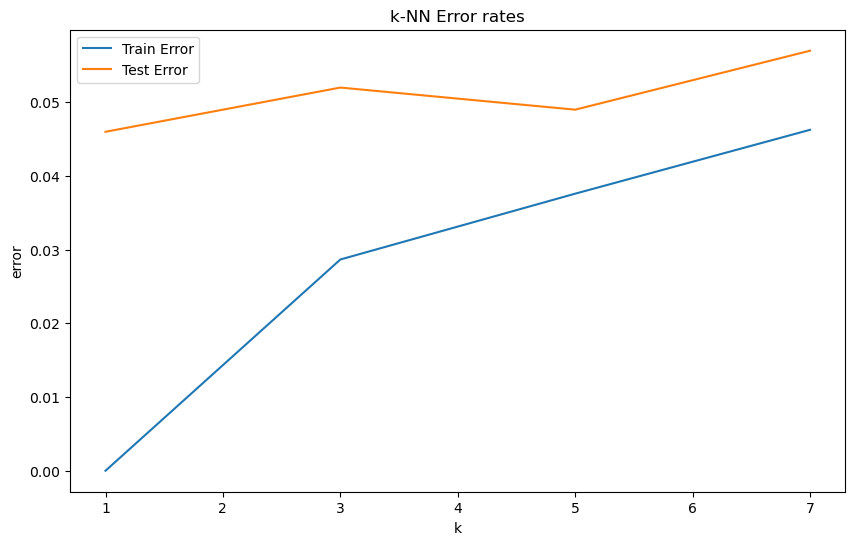

In [141]:
ks = range(1,9,2)
clfs=[KNeighborsClassifier(n_neighbors=k).fit(train_data, train_labels) \
      for k in ks]
train_scores = [trainError(clf, train_data, train_labels) for clf in clfs]
test_scores = [testError(clf, test_data, test_labels) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ks, train_scores, label="Train Error")
ax.plot(ks, test_scores, label="Test Error")
ax.set_xlabel('k')
ax.set_ylabel('error')
plt.title("k-NN Error rates")
plt.legend()
plt.show()

The error for the 1-NN on the train data is $0$, which is also minimum. The overall minimum on the test data is however around $k=5$.

## Hyper-Parameter Selection using Cross-Validation

A machine learning model has two types of parameters. 
1. The first type of parameters are the **model parameters** that are learned through a machine learning model
2. The second type of parameters are the **hyper-parameter** that we pass to the machine learning model prior to training. 

The `KNeighborsClassifier` has no internal model parameters (lazy learner) but provides two hyper-parameters:
1. `n_neighbors`: Number $k$ of neighbors to use by default for kneighbors queries.
2. `p`: The $p$ of the $L_p$ norm

### Cross validation for hyper-parameter selection


How to decide which hyper-parameter is the best? 

<div class="alert alert-block alert-danger" style="margin-top: 20px">
    The most important lesson of machine learning: never ever optimize (hyper-parameters of) your model on the test data.
</div>

This is a bad example of overfitting and a very common mistake in scientific publications. To make sure, our classifier generalizes to unseen data, we will use 3-fold-cross-validation on the train data and pick the model with highest average performance.

**Cross-validaton can be very slow, owing to the potentially large number of splits to test. Thus, make sure to use a subset of the train data.**

In [129]:
X_data = train_data[:1000]
y_labels = train_labels[:1000]

# Use X_data and y_labels from now on!

To implement the cross-validation we need to import ```cross_val_score``` from the ```sklearn.model_selection``` library.

In [130]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)
cross_val_score(knn, X_data, y_labels, cv=3).mean()

0.8530086973200746

### Task 9: Optimize hyper-parameter  `k` using cross-validation

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Complete the 

```python 
def score_all_k()
``` 

method to compute and return the 3-fold-cross-validation accuracy for each value in `n_neighbors_range`.
</div>

*Note: you can access global variables like `X_data` or `X_labels` within functions in python*

In [131]:
# use X_data and X_labels to fit the classifier
X_data = train_data[:1000]
y_labels = train_labels[:1000]

n_neighbors_range = np.arange(1,10)

def score_all_k():
    # The list of scores, one for each value in n_neighbors_range
    scores = []

    # YOUR CODE HERE
    for k in n_neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn_scores = cross_val_score(knn, X_data, y_labels, cv=3)  # 3-fold cross-validation
        average_score = np.mean(knn_scores)
        scores.append(average_score)
    
    # return scores
    return scores

Run the following tests to check if your implementation is correct

In [132]:
scores = score_all_k()

print ("Scores: ", list(zip(n_neighbors_range, np.array(scores))))
print ("Minimum at k: ", n_neighbors_range[np.argmin(np.array(scores))])

# check that your function returned 9 scores
assert len(scores) == n_neighbors_range.shape[0]

# check that the first score equals approx. 0.859
print('k=1 Score: {:.3f} should be approx. 0.859'.format(scores[0]))
assert abs(np.round(scores[0], 2) - 0.859) <= 0.01

# check that the last score equals approx. 0.839
print('k=9 Score: {:.3f} should be approx. 0.839'.format(scores[-1]))
assert abs(np.round(scores[-1], 2) - 0.839) <= 0.01


Scores:  [(1, 0.8590027152901404), (2, 0.831016645387903), (3, 0.8530086973200746), (4, 0.8540216863570157), (5, 0.8530176883470296), (6, 0.8460076843310377), (7, 0.8499997002991014), (8, 0.8480216743689798), (9, 0.8390066713420007)]
Minimum at k:  2
k=1 Score: 0.859 should be approx. 0.859
k=9 Score: 0.839 should be approx. 0.839


Let's plot the result:

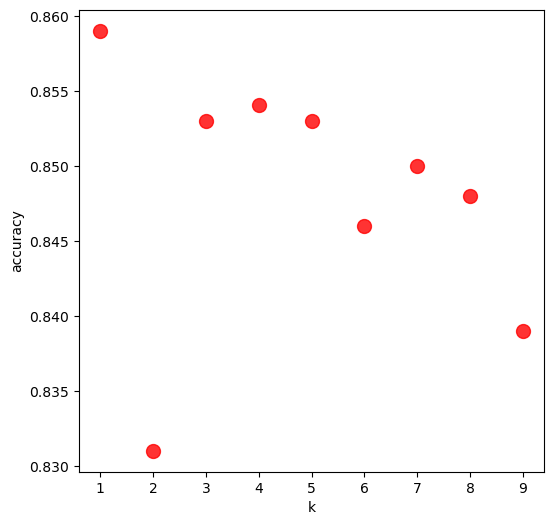

In [133]:
plt.figure(figsize=(6,6))
plt.xlabel('k')
plt.ylabel('accuracy')
_=plt.scatter(n_neighbors_range, score_all_k(), alpha=0.8, color="red", s = 100)

## Grid Search for Hyper-Parameter Selection

`scikit-learn` provides a utility method called `GridSearchCV` to test a range of hyper-parameters for the optimal values.

Let's create a dictionary of parameters and their corresponding values for training out model:

In [134]:
parameters = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9]
  }

The Grid Search algorithm can be very slow, owing to the potentially huge number of combinations to test. Furthermore, cross validation further increases the execution time and complexity. **Thus, make sure to use a subset of the train data, again.**

In [135]:
X_data = train_data[:1000]
y_labels = train_labels[:1000]

To implement the Grid Search algorithm we need to import ```GridSearchCV``` class from the ```sklearn.model_selection``` library.

In [136]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, parameters, cv=3, n_jobs=-1)

grid.fit(X_data, y_labels)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

Output the best parameters

In [137]:
print(f"Cross-Validation-Accuracy: {grid.best_score_}")
print(f"Best k: {grid.best_params_}")

Cross-Validation-Accuracy: 0.8590027152901404
Best k: {'n_neighbors': 1}


We can also get the test accuracy using the best parameters:

In [138]:
print(f"Test accuracy: {grid.score(test_data, test_labels)}")

Test accuracy: 0.9


### Task 10: Optimize hyper-parameters $k$ and $p$ using grid-search

<div class="alert alert-success alertsuccess" style="margin-top: 20px">

Implement the method
```python
def bestParameters():
```

that tries all combinations of values of `n_neighbors=[1,2,3,4,5,6,7,8,9]` and `p=[1,2,3]` to find the one combination of `(n_neighbors,p)` that maximize cross-validation accuracy using grid-search. Your method should return a tuple with 4 values `(n_neigbors,p,cross_validation_acc,test_acc)`.

</div>

*Note: In the following notebooks you should work with the subset of the train data of 1000 examples for performance reasons.*




In [139]:
# use X_data and X_labels to fit the classifier
X_data = train_data[:1000]
X_labels = train_labels[:1000]

n_neighbors_range = np.arange(1,10)
p_range = np.arange(1,4)

def bestParameters():
    best_n_neighbors = 0    
    best_p = 0    
    cross_validation_acc = 0
    test_acc = 0
    
    # YOUR CODE HERE
    for n_neighbors in n_neighbors_range:
        for p in p_range:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
            knn_scores = cross_val_score(knn, X_data, X_labels, cv=3)  # 3-fold cross-validation
            avg_cv_score = np.mean(knn_scores)
            
            if avg_cv_score > cross_validation_acc:
                cross_validation_acc = avg_cv_score
                best_n_neighbors = n_neighbors
                best_p = p
                
                # Train the model on the full training data
                knn.fit(X_data, X_labels)
                
                # Evaluate on the test set
                test_acc = knn.score(test_data, test_labels)
    
    return best_n_neighbors, best_p, cross_validation_acc, test_acc

Run the following tests to check if your implementation is correct

In [140]:
results = bestParameters()  

print("Cross validation accuracy: {:.3f}".format(results[2]))
print("Test accuracy: {:.3f}".format(results[3]))

## Check that your method returns a tuple
assert type(results) == tuple
best_n_neighbors, best_p, cross_validation_acc, test_acc = results

## Check that the best_n_neighbour is 3
print("Best k is {:d} should be 3".format(best_n_neighbors))
assert best_n_neighbors == 3

print("Best p is {:d}".format(best_p))

print("Cross validation accuracy is {:.3f} should be approx. 0.866".format(results[2]))
assert abs(cross_validation_acc-0.866) <= 0.01

## Check that the test_acc is 0.832
print('Test Accuracy is {:.3f} should be approx. 0.904'.format(test_acc))
assert abs(test_acc-0.904) <= 0.01


Cross validation accuracy: 0.866
Test accuracy: 0.904
Best k is 3 should be 3
Best p is 3
Cross validation accuracy is 0.866 should be approx. 0.866
Test Accuracy is 0.904 should be approx. 0.904


# Congratuations
At the end of this notebook you should have learned about:
- train accuracy and test accuracy
- hyper-parameters
- hyper-parameter optimization using cross-validation and grid-search
- using Scikit-Learn 

Now, hand in this assignment via Moodle.